# Simple Pair Test Using Alpha Vantage Quotes <a name="top"></a>
## Table of Contents
[Setup](#setup)<br>
[Intraday Data](#intraday)<br>
[Daily and Longer Data](#daily)<br>
[Spread](#spread)<br>

## Setup<a name="setup"></a>
 [top](#top)<br>
 Import needed modules and set-up plotting style.

In [1]:
import datetime as dt
import time
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import mkt_util as mu
%matplotlib inline

Alpha Vantage accepts tickers that closely follow Thomson Reuters, for example:
* DJIA: .DJI
* SPX: .SPX
* Apple: AAPL
* Marks & Spencer: MKS.L
* Canadian Tire: CTC-A.TO

Below is an example of getting Apple's intraday and daily quotes. We get the price history directly using two functions **get_intraday_prices** and **get_daily_prices**. These are found in my mkt_util package. The dataframes returned from these two functions are inputs into the Security object as is the ticker.<br>
We wait 12 seconds in between requests for data to avoid hitting the Alpha Vantage too quickly. It is free after all.

In [2]:
ticker = 'AAPL'
intraday = mu.get_intraday_prices(ticker)
time.sleep(12)
daily = mu.get_daily_prices(ticker)
aapl = mu.Security('AAPL', intraday, daily)

## Intraday Data<a name="intraday"></a>
 [top](#top)<br>
The intraday data in indexed by datetime including date and time. Charting recognizes the full clock so even though there may be no data during the market close, the time scale is still 24 hours. The plot linearly interpolates between the market close and open.

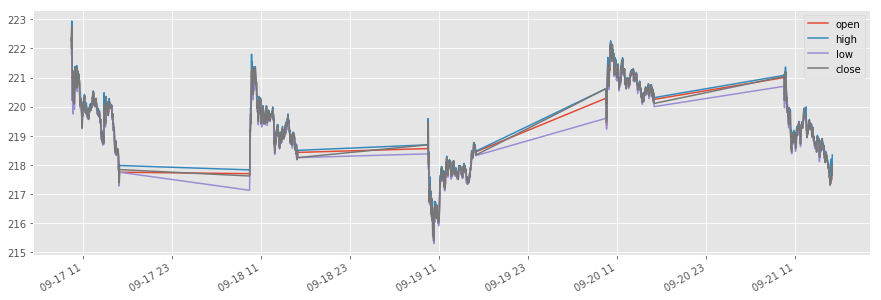

In [3]:
aapl.get_intraday().drop(columns=['volume']).plot(figsize=(15, 5));

## Daily and Longer Data <a name="daily"></a>
[top](#top)<br>
The daily chart can include up to 20 years of daily data. In this example we are using the "compact" output size with a limit of the latest 100 data points.

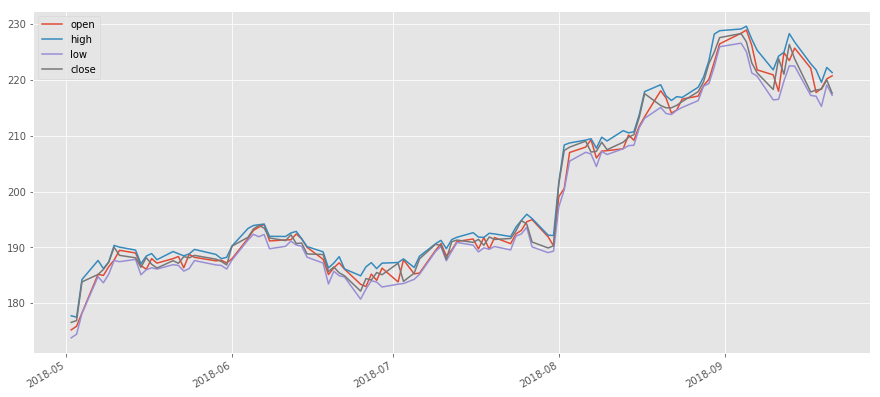

In [4]:
aapl.get_daily()[['open', 'high', 'low', 'close']].plot(figsize=(15, 7));

## Spread <a name="spread"></a>
[top](#top)<br>

In this section we're comparing the prices two of Canada's largest publicly traded life insurance compnies. The default time series length is 100 datapoints. For the study we want to two years plus a month of history. The extra month at the beginning allows us to have 20-day rolling histories 

In [5]:
# TO-DO refactor and put into function
ticker = 'MFC.TO'
if dt.datetime.fromtimestamp(os.path.getmtime('MFC.TO.csv')) < dt.datetime.today() - dt.timedelta(days=7):
    daily = mu.get_daily_prices(ticker, output='full')
    daily.to_csv('MFC.TO.csv')
    print('reading data from av')
else:
    daily = pd.read_csv('MFC.TO.csv')
    daily.index = pd.to_datetime(daily.iloc[:, 0])
    daily.drop(columns=['Unnamed: 0'], inplace=True)
    print('reading data from file')
mfc_to = mu.Security('MFC.TO', intraday, daily)

ticker = 'SLF.TO'
if dt.datetime.fromtimestamp(os.path.getmtime('SLF.TO.csv')) < dt.datetime.today() - dt.timedelta(days=7):
    daily = mu.get_daily_prices(ticker, output='full')
    daily.to_csv('MFC.TO.csv')
    print('reading data from av')
else:
    daily = pd.read_csv('SLF.TO.csv')
    daily.index = pd.to_datetime(daily.iloc[:, 0])
    daily.drop(columns=['Unnamed: 0'], inplace=True)  
    print('reading data from file')
slf_to = mu.Security('SLF.TO', intraday, daily)

reading data from file
reading data from file


Add rolling statistics for average, median and std as well as daily log return which we can use to calculate profitability. And plot prices and spreads. 

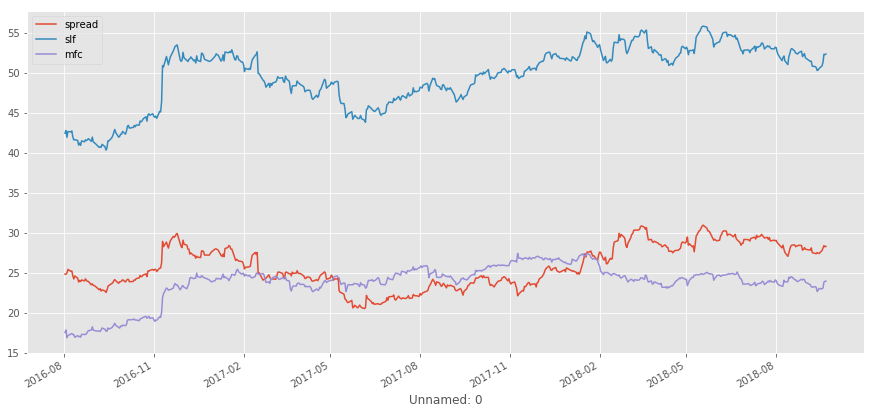

In [6]:
df = pd.DataFrame({'slf': slf_to.get_daily()['close'],
                   'mfc': mfc_to.get_daily()['close']})
df['spread'] = df['slf'] - df['mfc']
df['20-day avg'] = df['spread'].rolling(20).mean()
df['20-day median'] = df['spread'].rolling(20).median()
df['20-day std'] = df['spread'].rolling(20).std()
df['20-day up'] = df['20-day avg'] + df['20-day std']
df['20-day dn'] = df['20-day avg'] - df['20-day std']
df = df['2016-07-31':]
df['ret'] = np.log(df['spread']) - np.log(df['spread'].shift(1))
df[['spread', 'slf', 'mfc']].plot(figsize=(15, 7));

The chart above shows us the price of each stock as well as the spread. When the spread (red line) is low, we buy SLF and short MFC and when it is high we do the reverse and short SLF and buy MFC. We need to determine when is the spread high and when is it low.

Below is the a plot of the spread relative to its two year average.

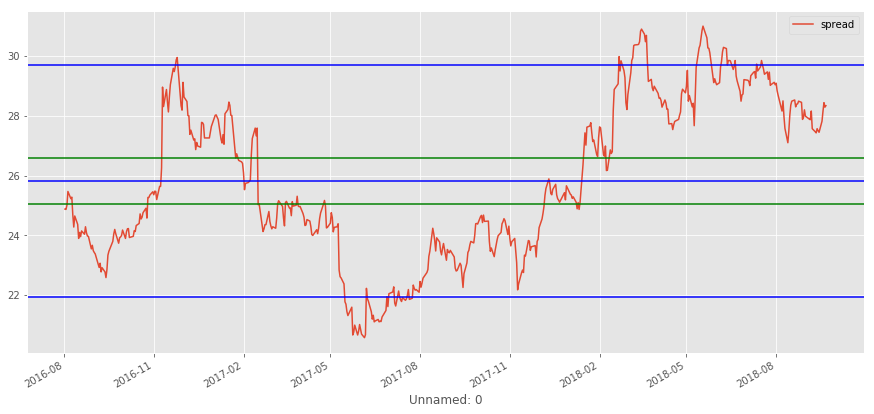

In [7]:
df[['spread']].plot(figsize=(15, 7))
plt.axhline(y=df['spread'].mean(), color='b')
plt.axhline(y=df['spread'].mean()*1.15, color='b')
plt.axhline(y=df['spread'].mean()*1.03, color='g')
plt.axhline(y=df['spread'].mean()*0.97, color='g')
plt.axhline(y=df['spread'].mean()*0.85, color='b');

Calculate the P&L of based on shorting when the spread exceeds 115% of the mean spread and covering the when the spread is 5% of the mean spread, and going long when the spread falls below 85% of the mean spread and covering when it is 95% of the mean spread. The levels at covering the trade seem conservative, however, we expect that once the spread is within the +/-5% bands, the propensity to revert to the mean spread would be less. 
**Whether or not this is the most profitable strategy using the spread in this way remains to be tested**

In [8]:
df = mu.create_fix_sprd_rule(df, 1.15, 1.05, 0.85, 0.95)

Short above: 29.70; Cover at 27.12
Long below: 21.96; Cover at 24.54


Plot the decisions to Trade where -1 is to be short and +1 is to be long.

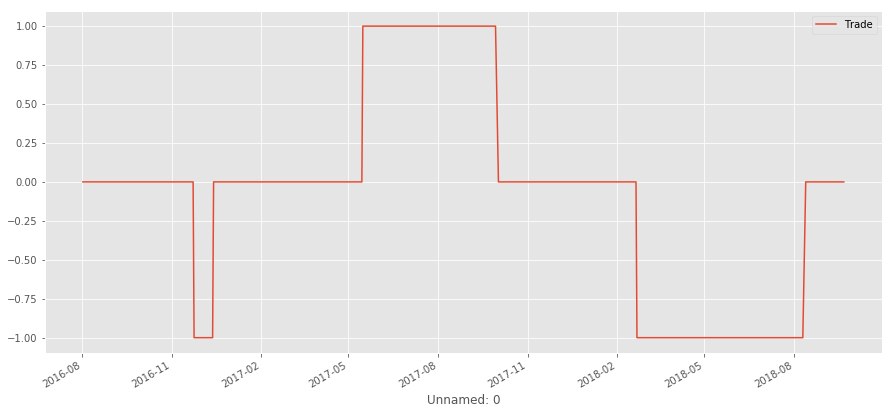

In [9]:
df[['Trade']].plot(figsize=(15, 7));

The profit for the the strategy calculated below:

In [10]:
df['profit'] = df['Trade'] * df['ret']
print('Long spread {:.4f}, Short spread {:.4f}, Total profit {:.4f}'
      .format((np.exp(df.loc[df['Trade'] == 1, 'profit'].sum())-1)*100,
              (np.exp(df.loc[df['Trade'] == -1, 'profit'].sum())-1)*100,
              (np.exp(df['profit'].sum())-1)*100))
print('Avg Daily profit {:.4f}, STD Daily profit {:.4f}, Daily Sharpe {:.4f}'
      .format(df['profit'].mean()*100,
              df['profit'].std()*100,
              df['profit'].mean()/df['profit'].std()*100))

Long spread 8.9366, Short spread 14.6924, Total profit 24.9420
Avg Daily profit 0.0415, STD Daily profit 0.8771, Daily Sharpe 4.7275


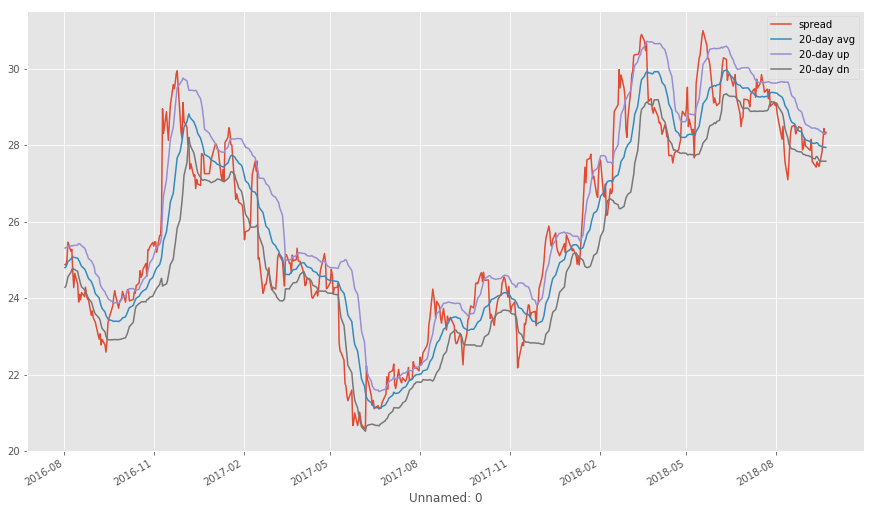

In [11]:
df[['spread', '20-day avg', '20-day up', '20-day dn']].plot(figsize=(15, 9));